<a href="https://colab.research.google.com/github/Evanaxander/Spatial-Detection-of-Slums-in-Dhaka/blob/main/Spatial_Detection_of_Slums_in_Dhaka.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Connecting Colab to Drive where pictures are uploaded**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Installing necessary libraries**

In [ ]:
# Install PyDrive to access shared folders
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
!pip install -U scikit-image

**Authenticate and create PyDrive client to interact with Google Drive**

In [ ]:

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
folder_id = '14Tg79c5xYn6sOQu28f5OGPUNZCxjjjWP'

**list of all files:**

In [ ]:
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

**Downloading only JPG files to Colab**







In [ ]:
image_files = []
for file in file_list:
    if file['title'].endswith('.jpg'):
        file.GetContentFile(file['title'])
        image_files.append(file['title'])
        print(f"Downloaded {file['title']}")

print(f"\nTotal images: {len(image_files)}")

Downloaded Molla Bosti-41.jpg
Downloaded Chandura Bosti-21.jpg
Downloaded Rupnagar Bosti_03.jpg
Downloaded Gabtoli Bosti-11.jpg
Downloaded Vashantek13.jpg
Downloaded Kalshi-13.jpg
Downloaded Gabtoli Bosti-22.jpg
Downloaded Kalshi-11.jpg
Downloaded Molla Bosti-11.jpg
Downloaded Chandura Bosti-12.jpg
Downloaded Molla Bosti-31.jpg
Downloaded Narayangonj-Adaamjee-21.jpg
Downloaded Molla Bosti-21.jpg
Downloaded Molla Bosti-32.jpg
Downloaded Rupnagar Bosti_02.jpg
Downloaded Vashantek11.jpg
Downloaded Chandura Bosti-22.jpg
Downloaded Gabtoli Bosti-12.jpg
Downloaded Molla Bosti-22.jpg
Downloaded Vashantek12.jpg
Downloaded Molla Bosti-42.jpg
Downloaded Rupnagar Bosti_01.jpg
Downloaded Rupnagar Bosti_05.jpg
Downloaded Kalshi-121.jpg
Downloaded Narayangonj-Adaamjee-41.jpg
Downloaded Gabtoli Bosti-21.jpg
Downloaded Narayangonj-Adaamjee-42.jpg
Downloaded Narayangonj-Adaamjee-31.jpg
Downloaded Vashantek14.jpg
Downloaded Chandura Bosti-11.jpg
Downloaded Narayangonj-Adaamjee-32.jpg
Downloaded Molla Bo

**Preprocessing**

In [ ]:
import cv2
import numpy as np
from skimage.feature import graycomatrix, graycoprops
from tqdm import tqdm

Density and vegetation

In [ ]:
 #Image Loading & Preprocessing
def process_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Feature extraction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.Canny(gray, 60, 160)

    # GLCM texture
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]


    density = np.sum(edges) / (img.shape[0] * img.shape[1])
    r, g, b = cv2.split(img)
    vegetation = np.mean((g - r) / (g + r + 1e-10))

    return {
        'image': img,
        'features': np.array([contrast, density, vegetation, *np.mean(img, axis=(0,1))])
    }

**Process all images**

In [ ]:
processed_data = []
for img_file in tqdm(image_files):
    processed_data.append(process_image(img_file))

100%|██████████| 33/33 [02:32<00:00,  4.63s/it]


**Feature Matrix**

In [ ]:
feature_matrix = np.array([d['features'] for d in processed_data])




**Standardize and cluster**

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()
scaled_features = scaler.fit_transform(feature_matrix)

kmeans = KMeans(n_clusters=2, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

In [ ]:
# After clustering, analyzing cluster centers to identify which is slum/non-slum
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)

# Determining which cluster is slums (higher density, lower vegetation)
slum_cluster = 0 if cluster_centers[0, 1] > cluster_centers[1, 1] else 1
print(f"Slum cluster: {slum_cluster} (Density: {cluster_centers[slum_cluster, 1]:.2f}, Vegetation: {cluster_centers[slum_cluster, 2]:.2f})")

Slum cluster: 0 (Density: 54.22, Vegetation: 4394323031.95)





**Heatmap Generation**

In [ ]:
def create_heatmap(img, features_scaler, kmeans_model, patch_size=64):
    h, w = img.shape[:2]
    heatmap = np.zeros((h, w))

    # Determining which cluster is slums based on density and vegetation
    cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
    slum_cluster = 0 if cluster_centers[0, 1] > cluster_centers[1, 1] else 1  # Higher density = slums

    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.size == 0: continue

            # Extracting features
            gray = cv2.cvtColor(patch, cv2.COLOR_RGB2GRAY)
            edges = cv2.Canny(gray, 60, 160)

            glcm = graycomatrix(gray, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
            contrast = graycoprops(glcm, 'contrast')[0, 0]
            density = np.sum(edges) / (patch_size ** 2)

            r, g, b = cv2.split(patch)
            vegetation = np.mean((g - r) / (g + r + 1e-10))

            # Predicting and assign 1 for slums, 0 for non-slums
            patch_features = features_scaler.transform([[contrast, density, vegetation, *np.mean(patch, axis=(0,1))]])
            prob = kmeans_model.predict(patch_features)[0]
            heatmap[i:i+patch_size, j:j+patch_size] = 1 if prob == slum_cluster else 0

    return cv2.GaussianBlur(heatmap, (25,25), 0)

**visualize**


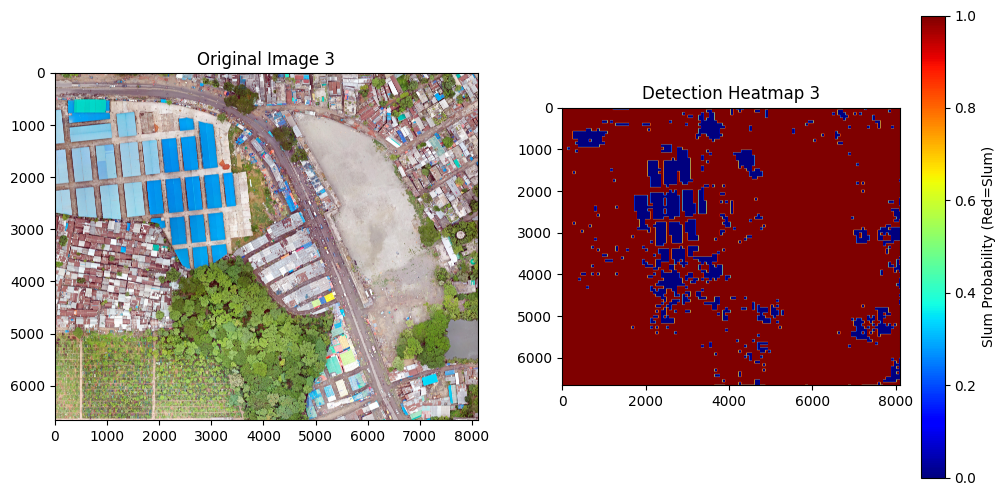

In [ ]:
import matplotlib.pyplot as plt

sample_idx = 3  # Try 0, 1, 2, etc. up to len(processed_data)-1
heatmap = create_heatmap(processed_data[sample_idx]['image'], scaler, kmeans)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(processed_data[sample_idx]['image'])
plt.title(f"Original Image {sample_idx}")

plt.subplot(122)
plt.imshow(heatmap, cmap='jet', vmin=0, vmax=1)
plt.colorbar(label='Slum Probability (Red=Slum)')
plt.title(f"Detection Heatmap {sample_idx}")
plt.show()

In [ ]:
# View another image (change the index number)
sample_idx = 5  # Now showing image 5 (try any valid index)
heatmap = create_heatmap(processed_data[sample_idx]['image'], scaler, kmeans)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(processed_data[sample_idx]['image'])
plt.title(f"Original Image {sample_idx}")  # Dynamic title shows index

plt.subplot(122)
plt.imshow(heatmap, cmap='jet', vmin=0, vmax=1)
plt.colorbar(label='Slum Probability (Red=Slum)')
plt.title(f"Detection Heatmap {sample_idx}")  # Consistent numbering
plt.show()

In [ ]:
import matplotlib.pyplot as plt

sample_idx = 0  # Change this to view different images
heatmap = create_heatmap(processed_data[sample_idx]['image'], scaler, kmeans)

plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(processed_data[sample_idx]['image'])
plt.title("Original Image")

plt.subplot(122)
plt.imshow(heatmap, cmap='jet', vmin=0, vmax=1)  # Explicitly set scale
plt.colorbar(label='Slum Probability (Red=Slum)')
plt.title("Detection Heatmap")
plt.show()

In [ ]:
import pandas as pd

results = pd.DataFrame({
    'image': image_files,
    'cluster': cluster_labels,
    'building_density': feature_matrix[:,1],
    'vegetation': feature_matrix[:,2]
})
results.to_csv('slum_predictions.csv', index=False)

# Save sample overlay
plt.imshow(processed_data[0]['image'])
plt.imshow(heatmap, cmap='jet', alpha=0.4)
plt.savefig('sample_result.jpg', dpi=300, bbox_inches='tight')